# Loan Prediction Model
## To build a loan prediction model using Random Forest, apply class imbalance handling, perform hyperparameter tuning, and save the trained model for use in a Flask application.

## Step 1: Import Required Libraries and Read the Dataset

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import joblib
import pickle

# Read the dataset
data = pd.read_csv("loan_approval_data.csv")

# Display the first few rows of the dataset
print(data.head())

    loan_id gender married dependents     education self_employed  \
0  lp001002   male      no          0      graduate            no   
1  lp001003   male     yes          1      graduate            no   
2  lp001005   male     yes          0      graduate           yes   
3  lp001006   male     yes          0  not graduate            no   
4  lp001008   male      no          0      graduate            no   

   applicantincome  coapplicantincome  loanamount  loan_amount_term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   credit_history property_area loan_status  
0             1.0         urban           y  
1             1.0         rural           n  
2             1.0   

## Step 2: Check the Shape, Info, and Initial Exploration of the Data

In [2]:
# Check the shape of the dataset
print(f"Dataset Shape: {data.shape}")

# Display the summary info of the dataset
print(data.info())

# Display a summary of the data to understand basic statistics
print(data.describe())

Dataset Shape: (614, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loan_id            614 non-null    object 
 1   gender             601 non-null    object 
 2   married            611 non-null    object 
 3   dependents         599 non-null    object 
 4   education          614 non-null    object 
 5   self_employed      582 non-null    object 
 6   applicantincome    614 non-null    int64  
 7   coapplicantincome  614 non-null    float64
 8   loanamount         592 non-null    float64
 9   loan_amount_term   600 non-null    float64
 10  credit_history     564 non-null    float64
 11  property_area      614 non-null    object 
 12  loan_status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None
       applicantincome  coapplicantincome  loanamount  loan_amount_term  \
count  

## Step 3: Check for Missing Values and Handle Them

In [3]:
# Check for missing values in the entire dataset
print("Missing Values Before Treatment:\n", data.isnull().sum())

# Fill missing values for categorical columns with the mode using `.loc`
categorical_cols = ['gender', 'married', 'dependents', 'self_employed', 'loan_amount_term', 'credit_history']
for col in categorical_cols:
    data.loc[:, col] = data[col].fillna(data[col].mode()[0])

# Fill missing values for 'loanamount' with the median using `.loc`
data.loc[:, 'loanamount'] = data['loanamount'].fillna(data['loanamount'].median())

# Check again for any remaining missing values
print("Missing Values After Treatment:\n", data.isnull().sum())

Missing Values Before Treatment:
 loan_id               0
gender               13
married               3
dependents           15
education             0
self_employed        32
applicantincome       0
coapplicantincome     0
loanamount           22
loan_amount_term     14
credit_history       50
property_area         0
loan_status           0
dtype: int64
Missing Values After Treatment:
 loan_id              0
gender               0
married              0
dependents           0
education            0
self_employed        0
applicantincome      0
coapplicantincome    0
loanamount           0
loan_amount_term     0
credit_history       0
property_area        0
loan_status          0
dtype: int64


In [4]:
# Drop redundant columns
data.drop(['loan_id'], axis=1, inplace=True)

## Step 4: Visualize the Distribution of the Target Column

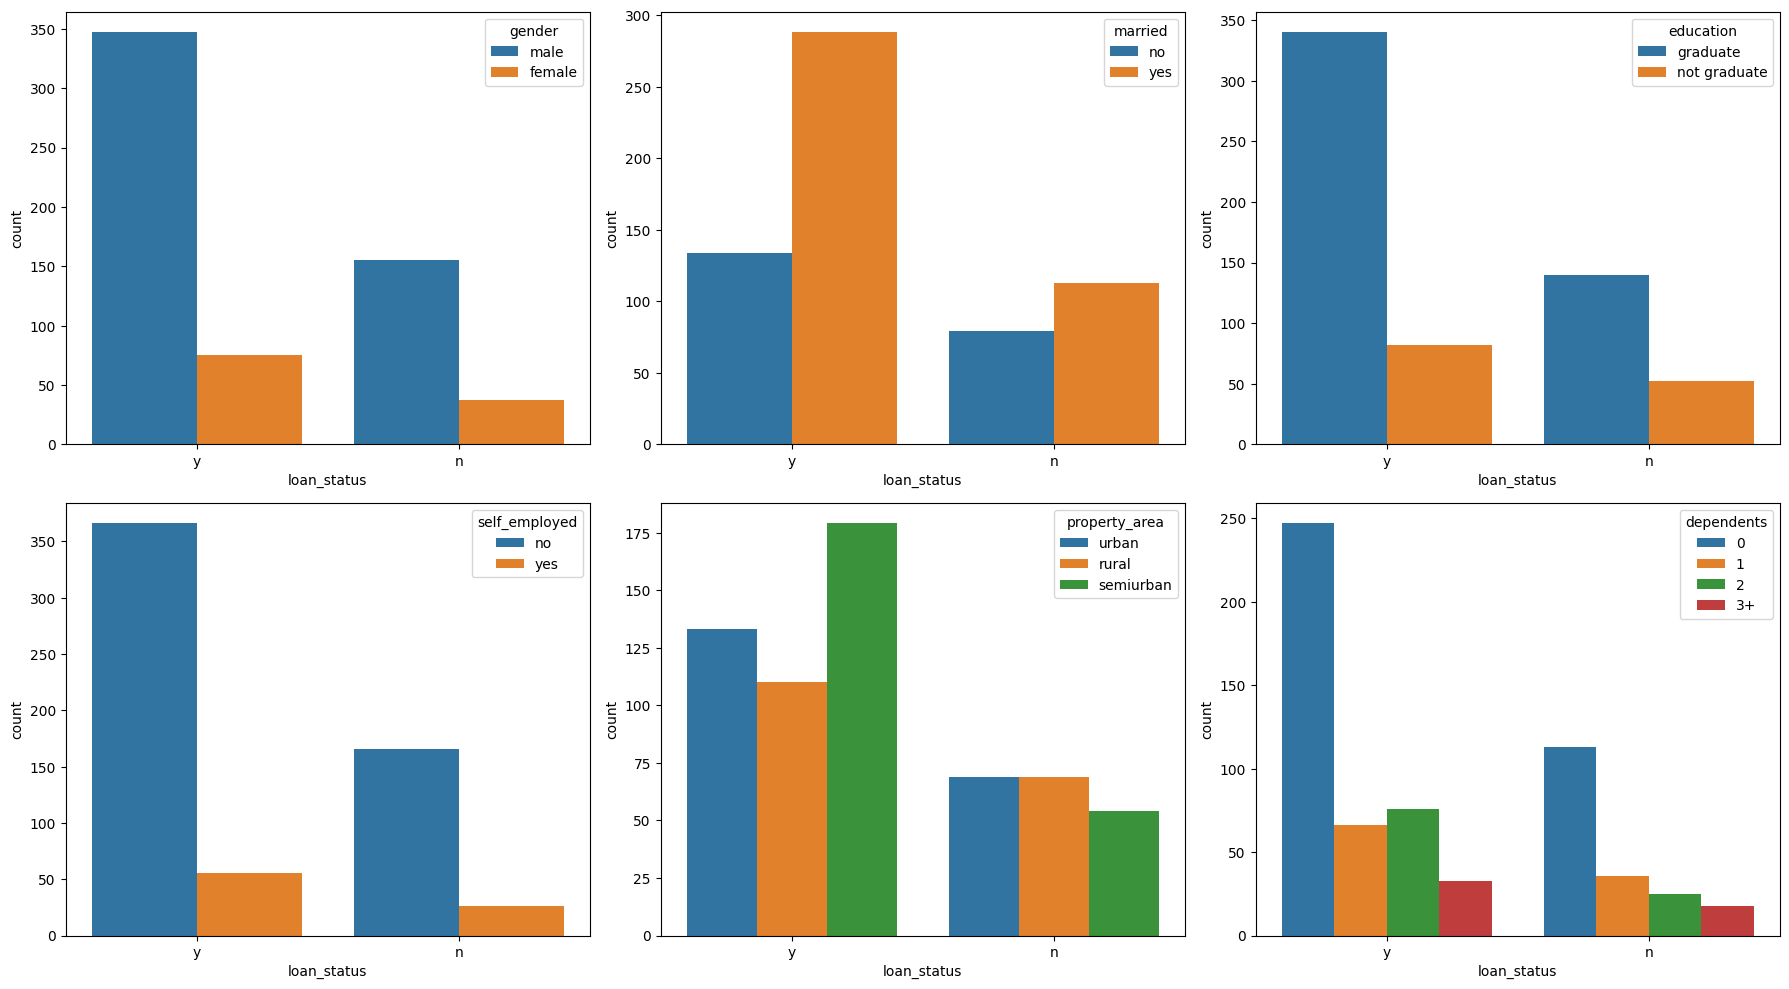

In [5]:
# Visualize the distribution of 'loan_status' with respect to categorical features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.countplot(x='loan_status', hue='gender', data=data, ax=axes[0, 0])
sns.countplot(x='loan_status', hue='married', data=data, ax=axes[0, 1])
sns.countplot(x='loan_status', hue='education', data=data, ax=axes[0, 2])
sns.countplot(x='loan_status', hue='self_employed', data=data, ax=axes[1, 0])
sns.countplot(x='loan_status', hue='property_area', data=data, ax=axes[1, 1])
sns.countplot(x='loan_status', hue='dependents', data=data, ax=axes[1, 2])

plt.tight_layout()
plt.show()

### Observations on Loan Approval Data:

1. **Gender:**
   - There is a clear skew in loan approvals based on gender.
   - **Males** have a higher approval rate compared to **females**.
   - This suggests that male applicants are more likely to get loan approvals.

2. **Marital Status:**
   - **Married** individuals are more likely to have their loans approved compared to **unmarried** individuals.
   - There is a notable gap between the approval rates of married and unmarried applicants, indicating marital status could be a significant factor in loan decisions.

3. **Education:**
   - **Graduates** have a significantly higher loan approval rate compared to **non-graduates**.
   - This suggests that educational qualifications positively influence the likelihood of loan approval.

4. **Self-Employment:**
   - Self-employed individuals have a lower approval rate compared to those who are not self-employed.
   - This could indicate that being employed by an organization might provide greater financial security in the eyes of the lender, leading to higher approval rates.

5. **Property Area:**
   - Applicants from **urban** and **semiurban** areas have higher loan approval rates compared to those from **rural** areas.
   - This might suggest that the perceived economic stability or opportunity in urban and semiurban regions contributes to better chances of securing loans.

6. **Dependents:**
   - Applicants with **0 dependents** have the highest approval rate, followed by those with **1 dependent**.
   - As the number of dependents increases, the approval rate decreases, indicating that applicants with more dependents may be seen as having higher financial obligations, which could reduce their chances of loan approval.

### Summary:
- The data shows that **male**, **married**, **graduate** applicants from **urban/semiurban** areas, with **0 to 1 dependent**, are more likely to have their loans approved.
- The patterns suggest that factors such as gender, marital status, education, employment status, property location, and dependents all play a role in influencing loan approval decisions.
  
These observations also conveys future adjustments to loan assessment criteria or provide insights into the demographic trends influencing loan approvals.

## Step 5: Encode the Categorical Data

In [6]:
# Encoding categorical variables using LabelEncoder
encoder = LabelEncoder()

categorical_features = ['gender', 'married', 'dependents', 'education', 'self_employed', 'property_area', 'loan_status']
for col in categorical_features:
    data[col] = encoder.fit_transform(data[col])

print(data.head())

   gender  married  dependents  education  self_employed  applicantincome  \
0       1        0           0          0              0             5849   
1       1        1           1          0              0             4583   
2       1        1           0          0              1             3000   
3       1        1           0          1              0             2583   
4       1        0           0          0              0             6000   

   coapplicantincome  loanamount  loan_amount_term  credit_history  \
0                0.0       128.0             360.0             1.0   
1             1508.0       128.0             360.0             1.0   
2                0.0        66.0             360.0             1.0   
3             2358.0       120.0             360.0             1.0   
4                0.0       141.0             360.0             1.0   

   property_area  loan_status  
0              2            1  
1              0            0  
2              2    

In [7]:
# Encode all categorical variables using pd.get_dummies for one-hot encoding
encoded_data = pd.get_dummies(data, drop_first=True)

print("Data after encoding:\n", encoded_data.head())

Data after encoding:
    gender  married  dependents  education  self_employed  applicantincome  \
0       1        0           0          0              0             5849   
1       1        1           1          0              0             4583   
2       1        1           0          0              1             3000   
3       1        1           0          1              0             2583   
4       1        0           0          0              0             6000   

   coapplicantincome  loanamount  loan_amount_term  credit_history  \
0                0.0       128.0             360.0             1.0   
1             1508.0       128.0             360.0             1.0   
2                0.0        66.0             360.0             1.0   
3             2358.0       120.0             360.0             1.0   
4                0.0       141.0             360.0             1.0   

   property_area  loan_status  
0              2            1  
1              0            0 

## Step 6: Separate the Target and Independent Features and Split the Data 

In [8]:
# Separate independent features and target variable
X = encoded_data.drop(columns=['loan_status'])
y = encoded_data['loan_status']

# Save the column names in the exact order
feature_columns = X.columns
joblib.dump(feature_columns, 'columns.pkl')

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training Set Shape: {X_train.shape}")
print(f"Test Set Shape: {X_test.shape}")

Training Set Shape: (429, 11)
Test Set Shape: (185, 11)


## Step 7: Build the model with SMOTE, Handle Class Imbalance, and Perform Hyperparameter Tuning

In [9]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Random Forest Classifier with Hyperparameter Tuning
rf = RandomForestClassifier(random_state=42)

# Set up hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_smote, y_train_smote)

# Get the best model
best_rf = grid_search.best_estimator_

# Train the Random Forest model
best_rf.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred = best_rf.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2f}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.51      0.62        65
           1       0.78      0.93      0.85       120

    accuracy                           0.78       185
   macro avg       0.79      0.72      0.74       185
weighted avg       0.79      0.78      0.77       185

Confusion Matrix:
 [[ 33  32]
 [  8 112]]
Accuracy Score: 0.78


An accuracy score of **78%** is a good start, but accuracy alone does not provide the full picture, especially in the case of imbalanced datasets. The below is  break down of the model’s performance based on the classification report and confusion matrix:

###  Observations:

1. **Precision**:
   - **Class 0 (Not Approved)**: 80%
   - **Class 1 (Approved)**: 78%

   The precision values suggest that when the model predicts a loan will not be approved (Class 0), it is correct **80%** of the time. For loans predicted to be approved (Class 1), the model is correct **78%** of the time. However, the relatively close precision scores indicate that the model is prone to misclassifying loans as approved when they are not, and vice versa.

2. **Recall**:
   - **Class 0**: 51%
   - **Class 1**: 93%

   The recall for **Class 1** (approved loans) is quite high at **93%**, meaning the model is good at identifying most approved loans. However, the recall for **Class 0** (not approved loans) is much lower at **51%**, indicating that the model struggles to correctly identify non-approved loans and tends to classify many of them as approved.

3. **F1-Score**:
   - **Class 0**: 62%
   - **Class 1**: 85%

   The F1-score balances precision and recall. The **F1-score for Class 1** is higher (**85%**), showing that the model performs well in identifying approved loans. However, the **F1-score for Class 0** is lower at **62%**, highlighting the model’s weaker performance when it comes to identifying non-approved loans.

4. **Confusion Matrix**:
   - **True Positives (TP)**: 112 (Correctly classified as approved)
   - **True Negatives (TN)**: 33 (Correctly classified as not approved)
   - **False Positives (FP)**: 32 (Incorrectly classified as approved when they are not)
   - **False Negatives (FN)**: 8 (Incorrectly classified as not approved when they should be approved)

   The confusion matrix shows that while the model correctly classifies most approved loans (112), it misclassifies a significant number of non-approved loans (32) as approved. This imbalance between true negatives and false positives indicates a bias towards predicting loans as approved.

### Interpretation:
- **The model performs well at predicting loan approvals (Class 1) but struggles to correctly identify non-approved loans (Class 0).**
- **The dataset likely has a class imbalance, with more approved loans than non-approved loans, which is affecting the recall for Class 0.**

### Future Recommendations:
1. **Handle Class Imbalance More Effectively**: Further tweak the `SMOTE` sampling strategy or explore other resampling techniques to balance the classes more effectively.
2. **Adjust Class Weights**: Modify the `class_weight` parameter in the Random Forest classifier to give more emphasis to Class 0 to improve its recall.
3. **Use Additional Evaluation Metrics**: Consider metrics like **ROC-AUC** or **G-Mean** that are better suited for imbalanced datasets to better evaluate the model’s performance across both classes.

### Conclusion:
For now, the model achieves reasonable accuracy, but adjustments to address class imbalance are recommended to improve the recall for non-approved loans.

## Step 8: Save the Model Using Pickle

In [10]:
# Save the model using pickle
with open("loan_approval_model.pkl", "wb") as file:
    pickle.dump(best_rf, file)

print("Model saved successfully as 'loan_approval_model.pkl'")

Model saved successfully as 'loan_approval_model.pkl'


# Loan Approval Model pkl Created